##### Playground for Developing the Contrastive Learning Model

# Setting up dataloaders

The different possible combinations have to be taken into account. A contrastive learning model can be trained with positive only or positive and negative pairs. The pairs must provide annotation.

In [1]:
import pandas as pd
import torch

train_data = pd.read_pickle('../data/04-0a_Train_Set.pkl')

In [2]:
train_data

,message,author_email,project,label
0,calcs/hazard/event_based/post_processing:\n\nM...,Lars.Butler@gmail.com,gem_oq-engine,0.0
1,added javadoc heading to hdf5 util class\n\n\n...,Lars.Butler@gmail.com,gem_oq-engine,0.0
2,added missing imports in db_tests/__init__.py ...,Lars.Butler@gmail.com,gem_oq-engine,0.0
3,"Fixed up a longer-running test, added slow attr",Lars.Butler@gmail.com,gem_oq-engine,0.0
4,calculators/hazard/event_based/core_next:\n\nR...,Lars.Butler@gmail.com,gem_oq-engine,0.0
...,...,...,...,...
47433,"Fixed ""is a"" op with Ident",tj@vision-media.ca,stylus_stylus,40.0
47434,removed old dynamic helper logic from the view...,tj@vision-media.ca,expressjs_express,40.0
47435,fixed property error due to parser not being p...,tj@vision-media.ca,stylus_stylus,40.0
47436,Fixed connect middleware for <I>.x,tj@vision-media.ca,stylus_stylus,40.0


### Positive Pairs

The code below takes two messages from the same author following each other in the dataset only once to build a dataloader.

In [3]:
import math

group_sizes = []
training_pairs = []

for group in train_data.groupby("author_email"):
    group_sizes.append(len(group[1]))
    pair = []
    for i, message in enumerate(group[1]['message']):
        pair.append(message)
        if i % 2 == 1:
            training_pairs.append(pair)
            pair = []

positive_training_pairs_count = 0
dist_training_pairs = []

for size in group_sizes:
    positive_training_pairs_count += math.comb(size, 2)
    dist_training_pairs.append(math.comb(size, 2))

If every message from one author would be combined with every other message of the same author, the resulting number of training pairs would be:

In [4]:
positive_training_pairs_count

51268322

The distribution would look like this:

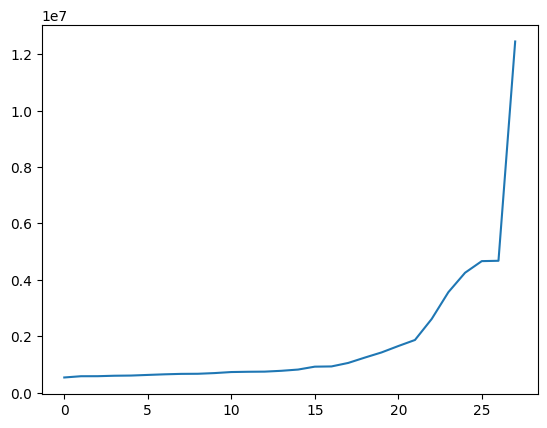

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(28), np.sort(dist_training_pairs))
plt.show()

Combining every message from one author with every other message from the same author can be achieved with this code:

In [ ]:
positive_training_pairs = []

for group in train_data.groupby("author_email"):
   for i, message_1 in enumerate(group[1]['message']):
       for message_2 in group[1]['message'].iloc[i+1:]:
           positive_training_pairs.append([message_1, message_2, 1])

### Negative Pairs

All possible negative pairs could be sampled by combining each message of one author with all messages from all other authors. The amount of possible negative pairs is calculated below:

In [22]:
negative_training_pairs_count = 0

train_data_groups = train_data.groupby("author_email")

dataset_size = len(train_data)

all_groups = [group for group in train_data_groups]
groups_calculated = []

for i, group in enumerate(train_data_groups):
    groups_calculated.append(group[0])
    for j, _ in enumerate(group[1]['message']):
        # don't take the groups anymore, that are already taken into consideration once by the first for loop
        negative_training_pairs_count += dataset_size - sum([len(train_data_groups.indices[group]) for group in groups_calculated])


In [23]:
negative_training_pairs_count

1073889881

Using all possible negative pairs would lead to a highly imbalanced training set since there are way less positive pairs. The number of negative pairs needs to be scaled down by a factor of:

In [24]:
scale_factor = negative_training_pairs_count / positive_training_pairs_count
scale_factor

20.946460486848

However, we cannot directly use this factor because of the different sizes of each group (per author).

We could try to cut the data, but then we need to do it equally for each group. Therefore, we check the minimum amount of messages per author and see, if there would still be enough negative training pairs.

In [25]:
min_group_size = math.inf

for i, group in enumerate(train_data_groups):
    min_group_size = min(min_group_size, len(train_data_groups.indices[group[0]]))

min_group_size

1035

In [26]:
negative_training_pairs_count = 0

groups_calculated = []

for i, group in enumerate(train_data_groups):
    groups_calculated.append(group[0])
    for j, _ in enumerate(group[1]['message'].iloc[:min_group_size]):
        # take the minimum group size for each group that was not yet taken into account by the first loop
        negative_training_pairs_count += sum([min_group_size if group[0] not in groups_calculated else 0 for group in all_groups])

negative_training_pairs_count

404923050

There are still enough messages. That means that we can just cut the amount of messages per author by a certain number and take all possible negative pairs with the remaining data.

In [58]:
negative_training_pairs_count = 0

cut_amount = 370

groups_calculated = []

for i, group in enumerate(train_data_groups):
    groups_calculated.append(group[0])
    for j, _ in enumerate(group[1]['message'].iloc[:cut_amount]):
        # take the minimum group size for each group that was not yet taken into account by the first loop
        negative_training_pairs_count += sum([cut_amount if group[0] not in groups_calculated else 0 for group in all_groups])

negative_training_pairs_count

51748200

In [59]:
scale_factor = negative_training_pairs_count / positive_training_pairs_count
scale_factor

1.0093601269025345

40 messages per author are required to build negative pairs that match the positive pairs in amount. Those can be taken randomly to minimize biases.

In [63]:
groups_calculated = []

negative_training_pairs = []

count = 0

for i, group in enumerate(train_data_groups):
    groups_calculated.append(group[0])
    negative_groups = [group if group[0] not in groups_calculated else None for group in all_groups]
    negative_groups = list(filter(lambda item: item is not None, negative_groups))
    for j, message_1 in enumerate(group[1]['message'].sample(n=cut_amount)):
        for negative_group in negative_groups:
            for message_2 in negative_group[1]['message'].sample(n=cut_amount):
                count += 1
                negative_training_pairs.append([message_1, message_2, -1])

In [75]:
count

51748200

The same scaling is done for validate and test set in the data preparation script.

### Trying a Model with the Sentence-Transformers framework

In [ ]:
# Source: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

MODEL = 'sentence-transformers/all-MiniLM-L6-v2'

In [ ]:
from sentence_transformers import SentenceTransformer

sentences = ["This is a sentence", "This is another sentence"]

model = SentenceTransformer(MODEL)
embedding = model.encode(sentences, convert_to_numpy=False)
embeddings = torch.stack(embedding)

In [ ]:
embeddings

In [ ]:
print(model)

### Do the Tokenization Yourself

This requires to not use the sentence-transformer framework.

In [ ]:
# Tutorial on Using the model without sentence transformers
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tokenize_function(examples):
    return tokenizer(examples, padding=True, truncation=True, return_tensors='pt')

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained(MODEL)

In [ ]:
encoding = tokenize_function(sentences)

embedding = model(**encoding)

In [ ]:
embedding

In [ ]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Perform pooling
sentence_embeddings = mean_pooling(embedding, encoding['attention_mask'])

# Normalize embeddings
sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)

While the embeddings stay the same no matter whether the sentence-transformers library is used or not, in the second version without sentence-transformers there is the grad_fn=\<DivBackward0\> ending.

# Cosine Distance Experiments

Here you can experiment what target value you need for what input tensors to find the right loss setup for training your model.

In [ ]:
loss_fn = torch.nn.CosineEmbeddingLoss()

x1 = torch.tensor([1, 0])
x2 = torch.tensor([0, 1])
# 1 if positive pair and -1 if negative pair
target = torch.tensor(-1)

loss_fn(x1, x2, target)

The loss should be minimized. Two completely different input tensors should have a loss of 1 if the corresponding training pair belongs together (=positive pair) and a loss of 0 if not (=negative pair).

In [ ]:
loss_fn = torch.nn.CosineEmbeddingLoss(margin=0.9)

x1 = torch.tensor([1, 1])
x2 = torch.tensor([0, 1])
# 1 if positive pair and -1 if negative pair
target = torch.tensor(-1)

loss_fn(x1, x2, target)

A margin can be applied: It works only on the negative training pairs and reduces the loss by the margin amount.

# Use GPU on Mac M1

https://towardsdatascience.com/installing-pytorch-on-apple-m1-chip-with-gpu-acceleration-3351dc44d67c

In [ ]:
import torch
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# Using the HuggingFace Dataloader

Do the tokenization before the model in a huggingface dataloader:
https://huggingface.co/docs/datasets/loading

In [1]:
import pandas as pd
import random

In [9]:
train_data = pd.read_pickle('../data/04-0a_Train_Set.pkl')
validate_data = pd.read_pickle('../data/04-0b_Validate_Set.pkl')
test_data = pd.read_pickle('../data/04-0c_Test_Set.pkl')

messages_1 = []
messages_2 = []
target = []

for i, group in enumerate(train_data.groupby("author_email")):
    pair = []
    for i, message in enumerate(group[1]['message']):
        if i % 2 == 0:
            messages_1.append(message)
            target.append(1 if random.choice([True, False]) else -1)
            training_pairs.append(pair)
            pair = []
        else:
            messages_2.append(message)


# Do this when taking a subset to ensure that shuffling happens before taking subsets
random.shuffle(training_pairs)

In [17]:
len(messages_2)

23712

In [19]:
from datasets import Dataset

dataset = Dataset.from_dict({'message_1': messages_1[:23712], 'messages_2': messages_2, 'target': target[:23712]})

In [44]:
from datasets import Dataset
from datasets.dataset_dict import DatasetDict

d = {
    'train': Dataset.from_dict({'messages_1': messages_1[:23712], 'messages_2': messages_2, 'target': target[:23712]}),
    'test': Dataset.from_dict({'messages_1': messages_1[:23712], 'messages_2': messages_2, 'target': target[:23712]})
}

dataset_dict = DatasetDict(d)

In [45]:
from transformers import AutoTokenizer

MODEL = 'bert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tokenize_function(examples):
    all_features = {}
    features_1 = tokenizer(examples['messages_1'], padding='max_length', truncation=True)
    features_2 = tokenizer(examples['messages_2'], padding='max_length', truncation=True)
    all_features['input_ids_1']      = features_1['input_ids']
    all_features['token_type_ids_1'] = features_1['token_type_ids']
    all_features['attention_mask_1'] = features_1['attention_mask']
    all_features['input_ids_2']      = features_2['input_ids']
    all_features['token_type_ids_2'] = features_2['token_type_ids']
    all_features['attention_mask_2'] = features_2['attention_mask']
    return all_features

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.map(tokenize_function, batched=True)

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

In [46]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['messages_1', 'messages_2', 'target', 'input_ids_1', 'token_type_ids_1', 'attention_mask_1', 'input_ids_2', 'token_type_ids_2', 'attention_mask_2'],
        num_rows: 23712
    })
    test: Dataset({
        features: ['messages_1', 'messages_2', 'target', 'input_ids_1', 'token_type_ids_1', 'attention_mask_1', 'input_ids_2', 'token_type_ids_2', 'attention_mask_2'],
        num_rows: 23712
    })
})

### Get a Model that is not Pretrained

In [1]:
from transformers import AutoConfig

model = AutoConfig.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')